In [29]:
import math

lphamin=-5;
alphamax=30;
alph0=20;     # angle of attack initial en degrees (alph=a+f)
u0 =0 ;       # initial position (0) 
a0 =-10;      # flight path angle in degrees Gamma
b0=0 ;        #Pitch rate attitude in degrees/sec^2 Theta dot
v0=9;         #initial airspeed in m/s

# Transformation in radians
alphr0=alph0*math.pi/180;
ar0=(a0*math.pi)/180;  # flight path angle in radians 
fr0=alphr0+ar0;   #pitch attitude in radians/sec Theta
br0=b0*math.pi/180;  #Pith rate attitude in radians/sec^2

timespan=0.1;
T0 =0;
T1 =18;        # in seconds

mpilot=90;    # kg (including harness and clothing = Hook-in weight)
h=1.2;        # in m (hang strap length)
Lb=0.4;       # 0.4 if forward , -0.74 if backward :distance between the cgpilot and the axis of the control bar,if trim change 'Pil_act'
Pil_act='Active'; # Choose Trim , or Active to make the pilot controlling the control bar or not.
Pil_pos='Prone';  # Choose Stand or Prone
Glider='Falcon';  #Falcon or T2C


Cmo=0.05;
I=102;        # in kg.m� according to G.V , I=110;% according to Cook study. Inertia Pilot+ Glider about CGTotal
AR=5.5;       # Aspect ratio Falcon 5.5
S=15.8;       # m^2 Falcon 170 area
c=1.9;        # m Falcon 170
mwing=22;     # kg
tpdist=8.5*c/100; # en m (distance between CGW et Tether point)
cgdist=0.06;  # distance between tether point and the CGW .
phid=14;      # angle in degrees between the downtube and the axis perpendicular to the keel
sweepd=31;    # Sweep angle at the quarterchord in degrees
Clwa=3.5;     # spanwise average value of the wing section lift curve slope (slope of CL between 5 and 15 degrees of alpha)
cbar=1.55;    # distance between the apex of the downtubes and the control bar axis (optional)
        
Scx=0.16;     # S.Cx of the pilot position. If prone : Scx=0.16. If stood: Scx=0.66
g = 9.81;     # N/kg or 
rho=1.22;     # kg/m^3


In [30]:
AC=[0, 0];     # Center of the landmark ( aerodynamic center)
M=mpilot+mwing;
Pp=mpilot*g;            # Force from mass
Pw=mwing*g;             # Force from mass  
phi=phid/360*2*math.pi; # conversion in radians
ksi=math.atan(Lb/h);         # angle between cg pilot and the downtubes in radians
ksid=ksi/2/math.pi*360;
sweep=sweepd/360*2*math.pi;



In [48]:
import scipy.integrate
import numpy

def motions(t, z):
    Lb = 0.4 
    Lb = 0.74  if t < 8 else 0.5
        
    alpha=z[2]-z[4];
    Clift=-16.6*alpha**3+11.48*alpha**2+1.3*alpha+0.038;
    Cdg=7.07*alpha**3-4.68*alpha**2+1.1*alpha-0.0144;

    lift=0.5*rho*S*Clift*z[3]**2;
    Dcdg=0.5*Cdg*rho*S*z[3]**2;     # Drag of the wing alone
    Dpilot=0.5*rho*Scx*z[3]**2;     # Drag of the pilot alone
    drag=Dcdg+Dpilot;               # Drag of the system (wing + pilot)
    
    AC=[0, 0];     # Center of the landmark ( aerodynamic center)
    M=mpilot+mwing;
    dyn=0.5*rho*z[3]**2*S;  # dynamic pressure
    
    Pp=mpilot*g;            # Force from mass
    Pw=mwing*g;             # Force from mass  
    phi=phid/360*2*math.pi; # conversion in radians
    ksi=math.atan(Lb/h);    # angle between cg pilot and the downtubes in radians
    ksid=ksi/2/math.pi*360;
    sweep=sweepd/360*2*math.pi;

    # Tether point (point d'accroche)
    tpx=tpdist*math.cos(z[2]);
    tpy=tpdist*math.sin(z[2]);

    # The wing
    xCGW=tpx+cgdist*math.cos(z[2]);
    yCGW=tpy+cgdist*math.sin(z[2]);
    CGW=numpy.array([xCGW, yCGW])

    #Pilot center of gravity
    # Pilote maintains the angle ksi with the downtubes . Forward or Backward
    #     case 'Active';
    xCGP=tpx+math.sin(z[2]+phi+ksi)*h;
    yCGP=tpy-math.cos(z[2]+phi+ksi)*h;

    CGP=numpy.array([xCGP, yCGP])    # Position CG pilot

    # Center of gravity total 
    xCGT=(mpilot*xCGP+mwing*xCGW)/M;
    yCGT=(mpilot*yCGP+mwing*yCGW)/M;
    CGT=numpy.array([xCGT, yCGT])     # Position CG of the system (pilot+wing)

    # The control bar
    xcbar=tpx+math.sin(z[2]+phi)*cbar
    ycbar=tpy-math.cos(z[2]+phi)*cbar;


    # Tau=z[4];
    Cx=-Dcdg;
    Cy=lift;

    d=numpy.sqrt(sum(CGT**2));  # norm

    # Cmq variable (from Methods for Estimating Stability and Control Derivatives for Standard Subsonic Airplanes (1973) -Roskam p51  )
    if AR<=6:
        K=0.7;
    if AR>6 and AR<10:
        K=0.1*math.sin(2*math.pi*AR/8)+0.8;
    if AR>=10:
        K=0.9;

    Xw=xCGT;
    Cmq=-K*Clwa*math.cos(sweep)*((((1./24)*(AR**3*math.tan(sweep)**2)/(AR+6*math.cos(sweep)))+1/8)+(AR*(2*(Xw/c)+0.5*(Xw/c))/(AR+2*math.cos(sweep))))
    
    # Damping
    Mq=(Cmq*z[5]*c**2*rho*z[3]*S)/4;
    Mq2=-0.5*rho*Cdg*S*(-2*z[5]*d**2*z[3]+z[5]**2*d**3); 

    XWT=xCGW-xCGT;
    XP=xCGP-xCGT;
    YP=yCGP-yCGT;


    # Differential equations
    dz = numpy.zeros(6)
    dz[1]=z[3];
    dz[2]=z[5];
    dz[3]=-g*math.sin(z[4])-(drag/M);
    dz[4]=(1/(z[3])*(-g*math.cos(z[4])+(lift/M)));
    # dz(5)=(Cmo.*dyn.*c-Cy.*xCGT-Cx.*(-yCGT)-Pw.*XWT-Pp.*XP+Mq+Mq2)./I; %
    # Without taking into account the drag of the pilot
    # Primary version of dz(5)
    # dz(5)=(-(-Cmo.*dyn.*c+(-Pw).*XWT+(-Pp).*XP+Cy.*xCGT+Cx.*(-yCGT)+(yCGP-yCGT).*Dpilot)+Mq+Mq2)./I;% drag of the pilot applied on CGP
    # Simplification of the signs of dz(5)
    dz[5]=(Cmo*dyn*c+Pw*XWT+Pp*XP-Cy*xCGT-Cx*(-yCGT)-(yCGP-yCGT)*Dpilot+Mq+Mq2)/I; # drag of the pilot applied on CGP
    return dz




In [49]:
res = scipy.integrate.solve_ivp(motions, (T0, T1), numpy.array([0, u0, fr0, v0, ar0, br0]), t_eval=numpy.linspace(T0, T1, 81))
#[t_1,z_1] = ode45('Motions',T0:timespan:T1,[u0 fr0 v0 ar0 br0]); % Runge-Kutta 4th and 5th order
dir(res)

['message',
 'nfev',
 'njev',
 'nlu',
 'sol',
 'status',
 'success',
 't',
 't_events',
 'y']

In [50]:
res.y.shape, res.t.shape

((6, 81), (81,))

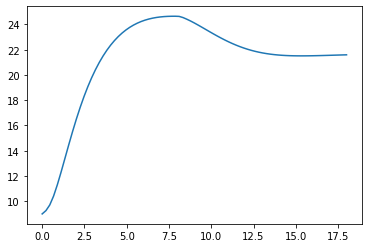

In [51]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.plot(res.t, res.y[3,:])

In [52]:
# B.Projection on x and y of U ( thank to gamma)
z = res.y
Uz=z[1,:];  # Vector U from Z
cosG=numpy.cos(z[4,:]);
sinG=numpy.sin(z[4,:]);

r=len(Uz);
dUz=numpy.zeros(r);
for i in range(1, r):
    dUz[i]=Uz[i]-Uz[i-1];

#ddUz=diag(dUz);% Diagonal for product
Ux=numpy.zeros(r);
for i in range(1, r):
    Ux[i]=dUz[i]*cosG[i-1]+Ux[i-1];

Uy=numpy.zeros(r);
for i in range(1, r):
    Uy[i]=dUz[i]*sinG[i-1]+Uy[i-1];



Text(0.5, 1.0, 'glide path')

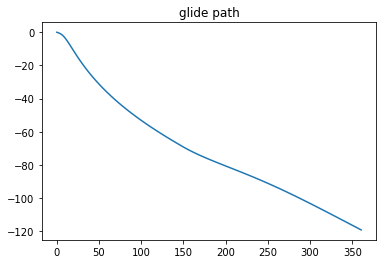

In [53]:
plt.plot(Ux, Uy)
plt.title("glide path")